In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
import re
import time
import os
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import scipy.stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm as lgb



from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Quality of image:
%config InlineBackend.figure_format = 'svg'


# Import my own functions from utils file:
import import_ipynb
from utils_home_prices import *

importing Jupyter notebook from utils_home_prices.ipynb


### Reading prepared dataset

In [2]:
dataDirectory = os.path.join(os.path.dirname(os.getcwd()),'Home_Prices\\data')
imageDirectory = os.path.join(os.path.dirname(os.getcwd()),'Home_Prices\\images\\Modeling')

In [3]:
df = pd.read_csv(dataDirectory + "\Melbourne_Tohid_Final.csv")
print(df.shape)
df.head(2)

(27000, 22)


,suburb,room,type,price,method,seller,distance,postcode,bathroom,parking,...,councilarea,lattitude,longtitude,region,age,year,season,month,period,history
0,Abbotsford,2,h,14.207553,S,Biggin,2.5,3067.0,1,1,...,Yarra City Council,-37.7996,144.9984,N_Metro,118,2016,Winter,3,2016-03,Old
1,Abbotsford,2,h,13.849912,S,Biggin,2.5,3067.0,1,0,...,Yarra City Council,-37.8079,144.9934,N_Metro,118,2016,Spring,4,2016-04,Old


### Applying scaler to the numerical features
- To prevent the impact of absolute values of variables (room number vs. land szie) and not letting some features to get dominant based on their scale, we will apply scaler.

- One of the numerical features is postal codes. However, this feature is not numerical one intrinsically. We should consider it as a categorical one.

- We do not need to apply scaler on target features. 

In [4]:
metadata = make_metadata(df)

catFeatures, catCnt, cat_df = make_typedf(df, metadata, 'categorical')
ordFeatures, ordCnt, ord_df = make_typedf(df, metadata, 'ordinal')
numFeatures, numCnt, num_df = make_typedf(df, metadata, 'numeric')
binFeatures, binCnt, bin_df = make_typedf(df, metadata, 'binary')

metadata

,role,type,dtype,uniqueCnt
varname,,,,
suburb,input,categorical,object,337
room,input,ordinal,int64,7
type,input,categorical,object,3
price,input,numeric,float64,2860
method,input,categorical,object,5
seller,input,categorical,object,349
distance,input,numeric,float64,212
postcode,input,numeric,float64,207
bathroom,input,ordinal,int64,8


In [5]:
scaleFeatures = ordFeatures + numFeatures
scaleFeatures = [x for x in scaleFeatures if x not in ('price', 'postcode')]

scaler = RobustScaler()
df[scaleFeatures] = scaler.fit_transform(df[scaleFeatures])

### Categorical Encoding:
- One hot encoding:
    - We use it for categorical features with few unique data.
    - type, method, region, history, period
- Target based encoding:
    - We use it when we have many unique input data.
    - suburb, seller, postcode, councilarea
    - It is better to before applying encoder, we do data spliting to prevent overfitting.

**One hot encoding:**    

In [6]:
print('Before dummification we have {} variables in train'.format(df.shape[1]))
df = pd.get_dummies(df, columns=['type', 'method', 'region', 'history', 'period', 'season'], drop_first=True)
print('After dummification we have {} variables in train'.format(df.shape[1]))

Before dummification we have 22 variables in train
After dummification we have 60 variables in train


### Spliting dataset:

In [7]:
X = df.drop('price', axis=1)
y = df['price'].to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=41)

**Target based encoding:**    

In [8]:
from category_encoders.target_encoder import TargetEncoder
# Categorical features for target based encoding:
cols = ['suburb', 'seller', 'postcode', 'councilarea']


encoder = TargetEncoder(cols=cols, return_df=True)
print('Before encoding we have {} features in dataset'.format(X_train.shape[1]))
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)
print('Before encoding we have {} features in dataset'.format(X_train.shape[1]))

Before encoding we have 59 features in dataset
Before encoding we have 59 features in dataset


In [9]:
X_test.head(2)

,suburb,room,seller,distance,postcode,bathroom,parking,landsize,area,councilarea,...,period_2017-11,period_2017-12,period_2018-01,period_2018-02,period_2018-03,period_2018-06,period_2018-10,season_Spring,season_Summer,season_Winter
25870,13.947385,1.0,13.581766,0.250000,13.947385,1.0,0.0,0.0,1.611765,13.967466,...,0,0,0,0,0,0,1,0,0,0
19066,13.775291,0.0,13.701068,-0.986842,13.775291,0.0,0.0,0.0,0.000000,13.808859,...,1,0,0,0,0,0,0,0,0,0


### Machine Learning:


In [10]:
models = pd.DataFrame(index= ['R2', 'RMSE'], columns=['LR', 'RF', 'XGB', 'LGB'])
models

,LR,RF,XGB,LGB
R2,NaN,NaN,NaN,NaN
RMSE,NaN,NaN,NaN,NaN


In [11]:
def analyze_prediction(y_predicted, y_observed, result_matrix = None, model_name=None):
    
    rmse = np.sqrt(mean_squared_error(y_true=y_observed, y_pred=y_predicted))
    r2 = r2_score(y_true=y_observed, y_pred=y_predicted)
    
    if (model_name != None):
        result_matrix.loc['R2', model_name] = r2
        result_matrix.loc['RMSE', model_name] = rmse
        

    print("R2, RMSE")
    return r2, rmse

### Exponential transformation of Price:
- Due to large scale of price values, we have already applied log transformation.
- To calculate the correct value of RMSE, we need to evaluate absolute value of price.
- For that matter, we have to apply exponential transformation.

In [12]:
print(y_test[:2])
y_test = np.e**y_test
print(y_test[:2])

           price
25870  14.220976
19066  13.753635
           price
25870  1500000.0
19066   940000.0


In [13]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

#Due to log transformation, we convert prediction values:
preds = np.e**preds
analyze_prediction(preds, y_test, result_matrix = models, model_name='LR')

R2, RMSE


(0.6907971195100118, 339020.38395683287)

In [14]:
model = RandomForestRegressor(random_state= 41)
model.fit(X_train, y_train)
preds = model.predict(X_test)

#Due to log transformation, we convert prediction values:
preds = np.e**preds
analyze_prediction(preds, y_test, result_matrix = models, model_name='RF')

R2, RMSE


(0.8081276995112621, 267060.8255478829)

In [15]:
model = XGBRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

#Due to log transformation, we convert prediction values:
preds = np.e**preds
analyze_prediction(preds, y_test, result_matrix = models, model_name='XGB')

R2, RMSE


(0.7977194039348685, 274208.65478625137)

In [16]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

#Due to log transformation, we convert prediction values:
preds = np.e**preds
analyze_prediction(preds, y_test, result_matrix = models, model_name='LGB')

R2, RMSE


(0.8050622929786837, 269185.69222230645)

In [17]:
model.get_params

<bound method LGBMModel.get_params of LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>

In [18]:
models

,LR,RF,XGB,LGB
R2,0.690797,0.808128,0.797719,0.805062
RMSE,339020,267061,274209,269186


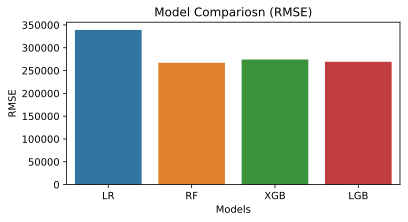

In [19]:
fig, ax = plt.subplots(figsize=(6,3))
sns.barplot(models.iloc[1].index, models.iloc[1].values, ax=ax)
ax.set_title('Model Compariosn (RMSE)')
ax.set_xlabel('Models')
ax.set_ylabel('RMSE');
plt.savefig(imageDirectory + '\\model_1.png', dpi=140,  bbox_inches='tight')

**LGB Parameter Tuning:**

In [20]:
# Based on my experiance, I do not need to tune n_estimators. A quite high value such as 1000 is recommended. 
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

In [21]:
num_leavesLst = [31, 35, 40, 45, 50, 60, 100]
max_depthLst = [-1, 5, 7, 9, 11]
learning_rateLst = [0.001, 0.01, 0.1, 0.2, 0.3]
# numleaves should be smaller than 2^max_depth
n_estimatorsLst =[100, 200, 500]
subsampleLst = [round(x,1) for x in np.linspace(start = 0, stop = 1, num = 10)]
reg_alphaLst = [0, 1, 1.2, 5, 10]
reg_lambdaLst =  [0, 1, 1.2, 1.4, 5, 10]

space = {'num_leaves': hp.choice('num_leaves', num_leavesLst),
         'max_depth': hp.choice('max_depth', max_depthLst),
         'learning_rate': hp.choice('learning_rate', learning_rateLst),
         'n_estimators': hp.choice('n_estimators', n_estimatorsLst),
         'subsample': hp.choice('subsample', subsampleLst),
         'reg_alpha': hp.choice('reg_alpha', reg_alphaLst),
         'reg_lambda': hp.choice('reg_lambda', reg_lambdaLst)
        }

best = 0
def get_acc_status(clf,X_,y):
    avg_score = cross_val_score(clf, X_, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    loss = -avg_score
    return {'loss': loss, 'status': STATUS_OK}

def obj_fnc(params): 
    global best

    clf = lgb.LGBMRegressor(**params)
    res = get_acc_status(clf,X_train,y_train)
    loss = res['loss']    
    
    if loss < best:
        best = loss
    #print ('new best:', -best, params)
    return (res)


# Trials object to track progress
bayes_trials = Trials()

# Optimize
best_params = fmin(obj_fnc, space, algo=tpe.suggest, max_evals=500, trials= bayes_trials)

100%|█████████████████████████████████████████████| 500/500 [12:22<00:00,  1.48s/trial, best loss: 0.18466377744828813]


In [22]:
best_params

{'learning_rate': 2,
 'max_depth': 0,
 'n_estimators': 1,
 'num_leaves': 5,
 'reg_alpha': 1,
 'reg_lambda': 4,
 'subsample': 4}

In [23]:
# Note: Output of the above cell is based on index which starts from 0.
# For example, for the learning rate we passed: [0.001, 0.01, 0.1, 0.2, 0.3]
# and in the output, it shows 2. By starting from 0, the index 2 indicates 0.1 as the learning rate. 

model = lgb.LGBMRegressor(learning_rate=0.1,
                          max_depth = -1,
                          n_estimators = 200,
                          num_leaves = 60,
                          reg_alpha = 1,
                          reg_lambda = 1.2,
                          subsample = 0.4,
                          random_state= 123)
model.fit(X_train, y_train)
preds = model.predict(X_test)

#Due to log transformation, we convert prediction values:
preds = np.e**preds

analyze_prediction(preds, y_test, result_matrix = models, model_name='LGB')

R2, RMSE


(0.8195150109953724, 259014.80555856522)

In [24]:
learning_rateLst = [0.009, 0.1, 0.11]
max_depthLst = [-1]
n_estimatorsLst =[200, 250]
num_leavesLst = [58, 60, 62]
# numleaves should be smaller than 2^max_depth
reg_alphaLst = [1]
reg_lambdaLst =  [1.1, 1.2, 1.3]
subsampleLst = [0.35, 0.4, 0.45]

space = {'num_leaves': hp.choice('num_leaves', num_leavesLst),
         'max_depth': hp.choice('max_depth', max_depthLst),
         'learning_rate': hp.choice('learning_rate', learning_rateLst),
         'n_estimators': hp.choice('n_estimators', n_estimatorsLst),
         'subsample': hp.choice('subsample', subsampleLst),
         'reg_alpha': hp.choice('reg_alpha', reg_alphaLst),
         'reg_lambda': hp.choice('reg_lambda', reg_lambdaLst)
        }

best = 0
def get_acc_status(clf,X_,y):
    avg_score = cross_val_score(clf, X_, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    loss = -avg_score
    return {'loss': loss, 'status': STATUS_OK}

def obj_fnc(params): 
    global best

    clf = lgb.LGBMRegressor(**params)
    res = get_acc_status(clf,X_train,y_train)
    loss = res['loss']    
    
    if loss < best:
        best = loss
    #print ('new best:', -best, params)
    return (res)


# Trials object to track progress
bayes_trials = Trials()

# Optimize
best_params = fmin(obj_fnc, space, algo=tpe.suggest, max_evals=200, trials= bayes_trials)

100%|██████████████████████████████████████████████| 200/200 [29:09<00:00,  8.75s/trial, best loss: 0.1841851945699572]


In [25]:
best_params

{'learning_rate': 1,
 'max_depth': 0,
 'n_estimators': 1,
 'num_leaves': 2,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 1}

In [ ]:
learning_rateLst = [0.009, 0.1, 0.11]
max_depthLst = [-1]
n_estimatorsLst =[200, 250]
num_leavesLst = [58, 60, 62]
# numleaves should be smaller than 2^max_depth
reg_alphaLst = [1]
reg_lambdaLst =  [1.1, 1.2, 1.3]
subsampleLst = [0.35, 0.4, 0.45]

In [26]:
model = lgb.LGBMRegressor(learning_rate=0.1,
                          max_depth = -1,
                          n_estimators = 250,
                          num_leaves = 62,
                          reg_alpha = 1,
                          reg_lambda = 1.2,
                          subsample = 0.4,
                          random_state= 123)
model.fit(X_train, y_train)
preds = model.predict(X_test)

#Due to log transformation, we convert prediction values:
preds = np.e**preds

r2New, rmseNew = analyze_prediction(preds, y_test, result_matrix = models, model_name='LGB')
print(r2New, rmseNew)

R2, RMSE


(0.8225557775492359, 256823.62849097326)

In [27]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

#Due to log transformation, we convert prediction values:
preds = np.e**preds
r2Base, rmseBase = analyze_prediction(preds, y_test, result_matrix = models, model_name='LGB')
print(r2Base, rmseBase )

R2, RMSE
0.8050622929786837 269185.69222230645


### Model Improvement: 4.81% decreasing in RMSE

In [28]:
improvement = round(100*(rmseBase-rmseNew)/rmseNew,2)
print("The improvement in RMSE: {}%".format(improvement))

The improvement in RMSE: 4.81%


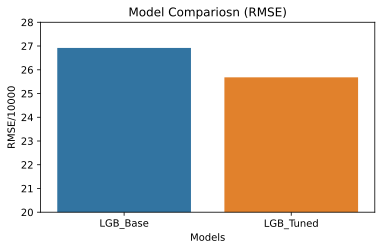

In [30]:
lst1 = ['LGB_Base', 'LGB_Tuned']
lst2 = [rmseBase, rmseNew]
lst2 = np.array(lst2)/10000

fig, ax = plt.subplots(figsize=(6,3.5))
sns.barplot(lst1, lst2, ax=ax)
ax.set_title('Model Compariosn (RMSE)')
ax.set_xlabel('Models')
ax.set_ylabel('RMSE/10000');
ax.set(ylim=(20, 28))
plt.savefig(imageDirectory + '\\model_Comparison.png', dpi=140,  bbox_inches='tight')